<a href="https://colab.research.google.com/github/ymuto0302/RW2025/blob/main/character_level_text_generation_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTMを用いた文字レベルテキスト生成
青空文庫から夏目漱石の「こころ」をダウンロードし，LSTMを用いた文字レベル文章生成モデルを構築する。

大まかな処理の流れは次のとおり：
1. 青空文庫からテキストをダウンロード
1. データセットを作成し訓練/検証に分割
1. LSTMモデルを訓練
1. 損失とPerplexityのグラフを表示
1. サンプルテキストを生成

カスタマイズ可能なハイパーパラメータは次のとおり：
- `sequence_length`: 入力シーケンス長（デフォルト100）
- `embedding_dim`: 埋め込み次元（デフォルト128）
- `hidden_dim`: LSTM隠れ状態次元（デフォルト256）
- `num_layers`: LSTM層数（デフォルト2）
- `dropout`: ドロップアウト率（デフォルト0.3）
- `batch_size`: バッチサイズ（デフォルト64）
- `learning_rate`: 学習率（デフォルト0.001）

なお，本コードの実行にあたってはGPU必須である。

## 必要なライブラリのインポート

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import requests
import re
import math
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm

# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用デバイス: {device}")

使用デバイス: cuda


## データセットの定義
テキストを固定長シーケンスで切り出し（スライディングウィンドウ方式），文脈（＝過去の文字列）から次の１文字を予測するというタスクをこなす。

In [ ]:
# 文字レベルのテキストデータセット
class TextDataset(Dataset):
    def __init__(self, text, sequence_length=100):
        self.sequence_length = sequence_length

        # 文字の集合を作成
        self.chars = sorted(list(set(text))) # テキスト内の全ての文字を重複なしで抽出
        self.char_to_idx = {char: i for i, char in enumerate(self.chars)} # 文字 → 数値の変換辞書
        self.idx_to_char = {i: char for i, char in enumerate(self.chars)} # 数値 → 文字の変換辞書
        self.vocab_size = len(self.chars)

        # テキストの数値化
        self.data = [self.char_to_idx[char] for char in text]
        print(f"語彙数: {self.vocab_size}")
        print(f"データ長: {len(self.data)}")

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        # 入力シーケンス
        input_seq = self.data[idx:idx + self.sequence_length]
        # ターゲット（次の文字）
        target = self.data[idx + self.sequence_length]

        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

# TextDataset クラスの動作チェック
test_text = "こんにちは"
sequence_length = 3
dataset = TextDataset(test_text, sequence_length)
for i in range(len(dataset)):
    input_seq, target = dataset[i]

    # 数値を文字に戻して表示
    input_chars = [dataset.idx_to_char[idx.item()] for idx in input_seq]
    target_char = dataset.idx_to_char[target.item()]

    print(f"インデックス {i}:")
    print(f"  入力シーケンス: {input_chars} → {''.join(input_chars)}")
    print(f"  ターゲット: '{target_char}'")
    print(f"  数値データ: 入力={input_seq.tolist()}, ターゲット={target.item()}")
    print()


語彙数: 5
データ長: 5
インデックス 0:
  入力シーケンス: ['こ', 'ん', 'に'] → こんに
  ターゲット: 'ち'
  数値データ: 入力=[0, 4, 2], ターゲット=1

インデックス 1:
  入力シーケンス: ['ん', 'に', 'ち'] → んにち
  ターゲット: 'は'
  数値データ: 入力=[4, 2, 1], ターゲット=3



## 文章生成モデル
このコードは，LSTMを使用した文字レベルの日本語テキスト生成システムを提供する。学習データから文字の連続パターンを覚えることで，与えられた開始文字列から自然な続きの文章を生成する。

In [ ]:
# 文章生成モデル
class LSTMTextGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256, num_layers=2, dropout=0.3):
        super(LSTMTextGenerator, self).__init__()

        self.vocab_size = vocab_size                   # 語彙サイズ（文字の種類数）
        self.embedding_dim = embedding_dim # 埋め込みベクトルの次元数
        self.hidden_dim = hidden_dim                # LSTM隠れ状態の次元数
        self.num_layers = num_layers                  # LSTMの層数

        # 埋め込み層：文字のインデックスを密なベクトルに変換
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM層
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           batch_first=True,
                            dropout=dropout if num_layers > 1 else 0)

        # ドロップアウト
        self.dropout = nn.Dropout(dropout)

        # 出力層：LSTMからの出力を語彙サイズの確率分布に変換
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        # 埋め込み
        embedded = self.embedding(x)  # shape=(batch, seq_len, embedding_dim)

        # LSTM
        lstm_out, hidden = self.lstm(embedded, hidden)  # shape=(batch, seq_len, hidden_dim)

        # ドロップアウト
        lstm_out = self.dropout(lstm_out)

        # 最後の時刻の出力を使用
        output = self.fc(lstm_out[:, -1, :])  # shape=(batch, vocab_size)

        return output, hidden

    # 隠れ状態の初期化
    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device) # 隠れ状態
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device) # メモリセル状態
        return (h0, c0)

In [ ]:
# 青空文庫のテキストをダウンロード
def load_aozora_text():
    # 夏目漱石の「こころ」を使用
    url = "https://www.aozora.gr.jp/cards/000148/files/773_14560.html"
    response = requests.get(url)
    response.encoding = 'shift_jis'

    # HTMLタグを除去
    text = re.sub(r'<[^>]+>', '', response.text)
    # 青空文庫の注記を除去
    text = re.sub(r'［[^］]*］', '', text)
    text = re.sub(r'｜', '', text)
    text = re.sub(r'《[^》]*》', '', text)

    # 不要な空白・改行を整理
    text = re.sub(r'\n+', '\n', text)
    text = re.sub(r'\s+', ' ', text)

    # 最初と最後の不要部分を除去
    start_idx = text.find('　私はその人を常に先生と呼んでいた。')
    end_idx = text.find('底本：')

    if start_idx != -1 and end_idx != -1:
        text = text[start_idx:end_idx]

    print(f"テキスト長: {len(text)}")
    return text

# 動作チェック
load_aozora_text()[:300]

テキスト長: 183615


' 夏目漱石 こころ こころ 夏目漱石 上 先生と私 一 私（わたくし）はその人を常に先生と呼んでいた。だからここでもただ先生と書くだけで本名は打ち明けない。これは世間を憚（はば）かる遠慮というよりも、その方が私にとって自然だからである。私はその人の記憶を呼び起すごとに、すぐ「先生」といいたくなる。筆を執（と）っても心持は同じ事である。よそよそしい頭文字（かしらもじ）などはとても使う気にならない。 私が先生と知り合いになったのは鎌倉（かまくら）である。その時私はまだ若々しい書生であった。暑中休暇を利用して海水浴に行った友達からぜひ来いという端書（はがき）を受け取ったので、私は多少の金を工面（くめ'

## Perplexityの計算
言語モデルの性能を評価するための指標 "Perplexity（困惑度）" を計算する関数である。
- 低いPerplexity = モデルの予測が正確（良い性能）
- 高いPerplexity = モデルの予測が不正確（悪い性能）

perplexity の定義は $perplexity=\exp(平均損失)$ である。

例えば，語彙サイズが 50文字の場合，perplexity の値は次のように評価される。
```
perplexity = 50.0  # ランダム予測と同程度（悪い）
perplexity = 10.0  # まあまあの性能
perplexity = 3.0   # 良い性能
perplexity = 1.0   # 完璧な予測（理論上の最小値）
```
直感的な理解として，perplexity=10.0 の場合，モデルが次の文字を予測するのに，平均10個の候補から迷っている状態にある。

In [ ]:
# Perplexityの計算
def calculate_perplexity(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)

            # バッチサイズの違いを考慮し，重み付けする
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

    avg_loss = total_loss / total_samples # 平均損失
    perplexity = math.exp(avg_loss)          # perplexity

    return perplexity

## モデルの学習

青空文庫のテキストを読み込み中...
テキスト長: 183615
データセットを作成中...
語彙数: 2122
データ長: 183615
モデルパラメータ数: 1738570
訓練開始...


100%|██████████| 2294/2294 [00:47<00:00, 48.31it/s]


Epoch [1/20], Train Loss: 4.0447, Val Perplexity: 33.0705


100%|██████████| 2294/2294 [00:46<00:00, 49.14it/s]


Epoch [2/20], Train Loss: 3.3554, Val Perplexity: 24.8119


100%|██████████| 2294/2294 [00:46<00:00, 49.05it/s]


Epoch [3/20], Train Loss: 3.1082, Val Perplexity: 21.4096


100%|██████████| 2294/2294 [00:46<00:00, 49.66it/s]


Epoch [4/20], Train Loss: 2.9372, Val Perplexity: 19.6936


100%|██████████| 2294/2294 [00:46<00:00, 49.58it/s]


Epoch [5/20], Train Loss: 2.8086, Val Perplexity: 18.7537


100%|██████████| 2294/2294 [00:46<00:00, 49.79it/s]


Epoch [6/20], Train Loss: 2.7096, Val Perplexity: 18.1420


100%|██████████| 2294/2294 [00:46<00:00, 49.87it/s]


Epoch [7/20], Train Loss: 2.6253, Val Perplexity: 17.9134


100%|██████████| 2294/2294 [00:46<00:00, 49.83it/s]


Epoch [8/20], Train Loss: 2.5559, Val Perplexity: 17.6479


100%|██████████| 2294/2294 [00:46<00:00, 49.84it/s]


Epoch [9/20], Train Loss: 2.4944, Val Perplexity: 17.6060


100%|██████████| 2294/2294 [00:46<00:00, 49.63it/s]


Epoch [10/20], Train Loss: 2.4425, Val Perplexity: 17.5473


100%|██████████| 2294/2294 [00:46<00:00, 49.66it/s]


Epoch [11/20], Train Loss: 2.3786, Val Perplexity: 17.4179


100%|██████████| 2294/2294 [00:46<00:00, 49.74it/s]


Epoch [12/20], Train Loss: 2.3352, Val Perplexity: 17.5026


100%|██████████| 2294/2294 [00:46<00:00, 49.77it/s]


Epoch [13/20], Train Loss: 2.2949, Val Perplexity: 17.5195


100%|██████████| 2294/2294 [00:46<00:00, 49.64it/s]


Epoch [14/20], Train Loss: 2.2548, Val Perplexity: 17.8516


100%|██████████| 2294/2294 [00:46<00:00, 49.61it/s]


Epoch [15/20], Train Loss: 2.2233, Val Perplexity: 18.1774


100%|██████████| 2294/2294 [00:46<00:00, 49.68it/s]


Epoch [16/20], Train Loss: 2.1932, Val Perplexity: 18.3303


100%|██████████| 2294/2294 [00:46<00:00, 49.74it/s]


Epoch [17/20], Train Loss: 2.1652, Val Perplexity: 18.2420


100%|██████████| 2294/2294 [00:46<00:00, 49.82it/s]


Epoch [18/20], Train Loss: 2.1405, Val Perplexity: 18.4478


100%|██████████| 2294/2294 [00:46<00:00, 49.81it/s]


Epoch [19/20], Train Loss: 2.1144, Val Perplexity: 19.0121


100%|██████████| 2294/2294 [00:46<00:00, 49.71it/s]


Epoch [20/20], Train Loss: 2.0922, Val Perplexity: 19.2537

最終検証Perplexity: 19.2537


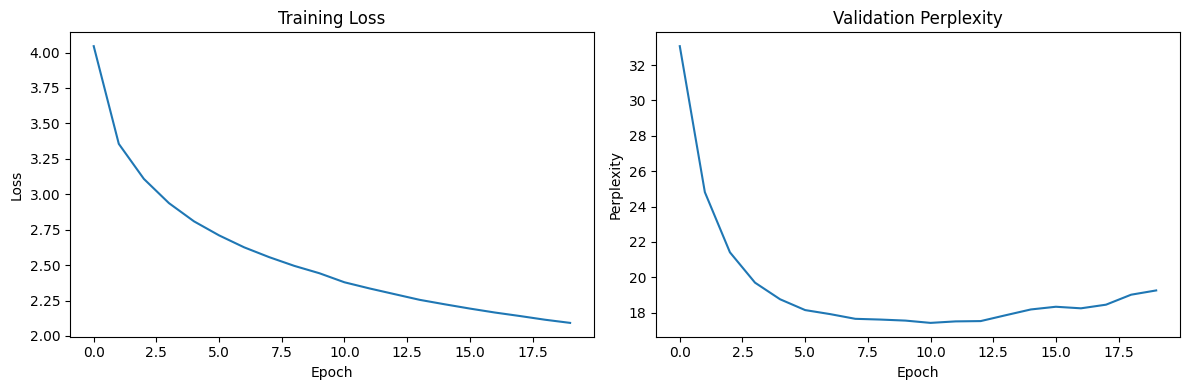

In [ ]:
# モデルの訓練
def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # 学習率スケジューリング：10エポック毎に学習率を0.9倍する
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    train_losses = []
    val_perplexities = []

    for epoch in range(num_epochs):
        model.train() # 訓練モードに設定
        epoch_loss = 0

        for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()                    # 勾配リセット
            outputs, _ = model(inputs)           # 順伝搬
            loss = criterion(outputs, targets)  # 損失計算
            loss.backward()                              # 逆伝搬

            # 勾配クリッピング（LSTMでは勾配が指数的に増大するケースがあるため）
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step() # パラメータ更新
            epoch_loss += loss.item()

            '''
            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
            '''

        scheduler.step() # 学習率の更新

        # 検証
        val_perplexity = calculate_perplexity(model, val_loader, criterion)
        avg_train_loss = epoch_loss / len(train_loader)

        train_losses.append(avg_train_loss)
        val_perplexities.append(val_perplexity)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Perplexity: {val_perplexity:.4f}')

    return train_losses, val_perplexities

# 結果の可視化
def visualize_training_history(train_losses, val_perplexities):
    plt.figure(figsize=(12, 4))

    # 訓練データに対する損失
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # 検証データに対する perplexity
    plt.subplot(1, 2, 2)
    plt.plot(val_perplexities)
    plt.title('Validation Perplexity')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')

    plt.tight_layout()
    plt.show()

# === ここからメイン実行部分 ===

# データの読み込み
print("青空文庫のテキストを読み込み中...")
text = load_aozora_text()

# データセットの作成
print("データセットを作成中...")
dataset = TextDataset(text, sequence_length=100)

# 訓練・検証用に分割
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# データローダーの作成
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# モデルの初期化
model = LSTMTextGenerator(
    vocab_size=dataset.vocab_size,
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2,
    dropout=0.3
).to(device)

print(f"モデルパラメータ数: {sum(p.numel() for p in model.parameters())}")

# 訓練
print("訓練開始...")
train_losses, val_perplexities = train_model(model, train_loader, val_loader, num_epochs=20)

# 最終的なPerplexityを表示
final_perplexity = val_perplexities[-1]
print(f"\n最終検証Perplexity: {final_perplexity:.4f}")

# 訓練結果の可視化
visualize_training_history(train_losses, val_perplexities)


## テキスト生成

In [ ]:
# テキスト生成
def generate_text(model, dataset, seed_text, length=200, temperature=0.8):
    model.eval()

    # シードテキストを数値化
    chars = [dataset.char_to_idx.get(char, 0) for char in seed_text]
    input_seq = torch.tensor(chars, dtype=torch.long).unsqueeze(0).to(device)

    generated = seed_text
    hidden = model.init_hidden(1)

    with torch.no_grad():
        for _ in range(length):
            output, hidden = model(input_seq, hidden)

            # 温度パラメータを適用
            output = output / temperature
            probs = torch.softmax(output, dim=-1)

            # 次の文字をサンプリング
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = dataset.idx_to_char[next_char_idx]

            generated += next_char

            # 入力を更新
            input_seq = torch.tensor([[next_char_idx]], dtype=torch.long).to(device)

    return generated

# テキスト生成のサンプル
print("\n生成されたテキスト:")
print("-" * 50)
seed_text = "私は"
generated_text = generate_text(model, dataset, seed_text, length=200, temperature=0.8)
print(generated_text)

# より保守的な生成
print("\n保守的な生成 (temperature=0.5):")
print("-" * 50)
conservative_text = generate_text(model, dataset, seed_text, length=200, temperature=0.5)
print(conservative_text)



生成されたテキスト:
--------------------------------------------------
私は知らないようにして、「まあ病気に暮らしているものと、それを東京へ帰って来るように、ただ道を折れて、「すぐいいですか」 「何にも思い出したから」 「正直するのは、私はむしろ「胸に仰山（とんあん）しているのが鎌倉（かまくら）へ帰った。そうして若い女の事のある事をやりました。若い様子は、大抵外（ほか）になっているのです。それでもあなたに対して、まだ私は世間だったのです。仏（お）まったままは、いつなもので

保守的な生成 (temperature=0.5):
--------------------------------------------------
私はその人のまだあったのです。私はそれを忘れていたところもありません。私はただいつもの事を考えたと、それを隠しているのです。私はそれでも名掛茶屋へ行って、自分の室に入れて来たのです。 私はそれを苦笑していたのです。自分は自分の身体（からだ）が、私の方が有難（ぞうせつ）になっているのです。 私はその時の私にはそれをそこに立て懸けて、その時の前に跪（ひざまず）いた事のできないのです。それからこういう言葉が


## モデルの保存
学習に時間を要した(GPUを消費した)から，もったいなくて保存する。

In [ ]:
# モデルの保存
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': dataset.vocab_size,
    'char_to_idx': dataset.char_to_idx,
    'idx_to_char': dataset.idx_to_char,
    'model_config': {
        'embedding_dim': 128,
        'hidden_dim': 256,
        'num_layers': 2,
        'dropout': 0.3
    }
}, 'lstm_text_generator.pth')